<a href="https://colab.research.google.com/github/Remil-Maha/ML-Notebooks/blob/main/Classification_LogisticRegression_MNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Loading data:**

In [2]:
df = pd.read_csv("spam.csv", encoding='latin-1')
df.dropna(how="any",inplace=True , axis = 1)#Supprime une colonne si au moins un NaN est présent.
df.columns=['label','message']
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.isnull().sum()

,0
label,0
message,0


In [4]:
df.duplicated().any()

True

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.duplicated().any()

False

**Distribution of spam vs.ham**

In [7]:
category_count=df['label'].value_counts()
print(category_count)

label
ham     4516
spam     653
Name: count, dtype: int64


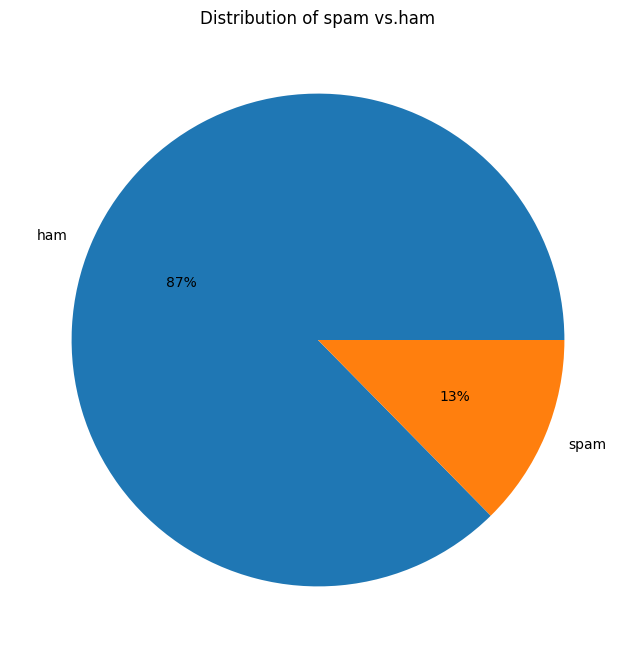

In [8]:
#Plotting the pie chart
plt.figure(figsize=(8,8))
plt.pie(category_count,labels=category_count.index , autopct='%1.0f%%')
plt.title('Distribution of spam vs.ham')
plt.show()

**Text Visualization:**

In [9]:
label = LabelEncoder()
df['label'] = label.fit_transform(df['label'])
df.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Preprocessing:**

In [10]:
#Lower Case  :
df['message'] = df['message'].str.lower()
df.head()

,label,message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [11]:
#Removing extra Whitespaces
df['message'] = df['message'].str.strip()
df.head()

,label,message
0,0,"go until jurong point, crazy.. available only ..."
1,0,ok lar... joking wif u oni...
2,1,free entry in 2 a wkly comp to win fa cup fina...
3,0,u dun say so early hor... u c already then say...
4,0,"nah i don't think he goes to usf, he lives aro..."


In [12]:
#Remove HTML Tags
def remove_html_tags(text):
  soup = BeautifulSoup(text,'html.parser')
  return soup.get_text()
df['message'] = df['message'].apply(remove_html_tags)

In [13]:
#Remove Urls
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

# Apply the function to the 'Text' column
df['message'] = df['message'].apply(remove_urls)

In [14]:
#Remove Punctuations
punctuation = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', punctuation))

df['message'] = df['message'].apply(remove_punctuation)

In [16]:
#Remove Special Characters
def remove_special_characters(text):
  pattern  = r'[^a-zA-Z0-9\s]'
  return re.sub(pattern,'',text)

df['message'] = df['message'].apply(remove_special_characters)


In [15]:
#Remove Numeric values  :
def remove_numeric(text):
  return re.sub(r'\d+','',text)
df['message'] = df['message'].apply(remove_numeric)

In [17]:
#Remove non-alpha Numeric values  :
def remove_non_alphanumeric(text):
  return re.sub(r'[^a-zA-Z0-9\s]','',text)
df['message'] = df['message'].apply(remove_non_alphanumeric)

In [18]:
#Handling ChatWords
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}
# Function to replace chat words with their full forms
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

# Apply replace_chat_words function to 'Text' column
df['message'] = df['message'].apply(replace_chat_words)

In [19]:
#Handling Stop Words
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Function to remove stop words from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply remove_stopwords function to 'Text' column
df['message'] = df['message'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Stemming**

In [20]:
porter_stemmer = PorterStemmer()
df['message_stemmed'] = df['message'].apply(lambda x : ' '.join([porter_stemmer.stem(word) for word in x.split()]))

**Model Building:**

**Text Vectorization**

In [21]:
cv= CountVectorizer()
X =cv.fit_transform(df['message_stemmed']).toarray()
y=df['label']

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=42)

In [26]:
#Logistic regression with tunned parameters :
lr_model = LogisticRegression(C=0.1 ,solver='liblinear')
lr_model.fit(X_train,y_train)
lr_pred = lr_model.predict(X_test)

### **📌 Explication de la Régression Logistique avec Paramètres Ajustés (`Tuned Parameters`)**
---
Ce code met en place une **régression logistique** en utilisant **des paramètres ajustés** pour améliorer la performance du modèle.

---

## **1️⃣ Décomposition du Code**
```python
# Importation
from sklearn.linear_model import LogisticRegression
```

```python
# Création du modèle de régression logistique avec des paramètres ajustés
lr_model = LogisticRegression(C=0.1, solver='liblinear')
```
📌 **Explication des paramètres** :
- `C=0.1` : **Paramètre de régularisation** (inverse de la force de régularisation). Une valeur plus petite signifie une régularisation plus forte (évite le sur-ajustement).
- `solver='liblinear'` : **Algorithme d'optimisation utilisé** pour la descente de gradient (adapté aux petits datasets et aux problèmes de classification binaire).

```python
# Entraînement du modèle sur les données d'entraînement
lr_model.fit(X_train, y_train)
```
✅ **Le modèle apprend à partir des données d'entraînement (`X_train`, `y_train`).**

```python
# Prédiction sur les données de test
y_pred_lr = lr_model.predict(X_test)
```
✅ **Utilisation du modèle entraîné pour prédire les classes des nouvelles données (`X_test`).**

---

## **2️⃣ Explication de la Régression Logistique**
### **🟢 C'est quoi ?**
La **régression logistique** est un algorithme de classification qui permet de prédire la **probabilité** qu'une observation appartienne à une certaine classe.

Elle est basée sur la fonction **sigmoïde** :
\[
P(y=1 | X) = \frac{1}{1 + e^{-(wX + b)}}
\]
où :
- \( X \) = variables d'entrée (features)
- \( w \) = coefficients du modèle
- \( b \) = biais
- \( e \) = exponentielle
- \( P(y=1|X) \) = probabilité d'appartenance à la classe 1

---

## **3️⃣ Pourquoi Ajuster les Paramètres ?**
L'ajustement des **hyperparamètres (`C` et `solver`)** permet :
✅ **D'éviter le sur-ajustement** (overfitting)  
✅ **D'améliorer la précision du modèle**  
✅ **D'adapter le modèle aux données disponibles**  

---

## **4️⃣ Résumé**
🚀 **Ce code entraîne une régression logistique optimisée avec `C=0.1` et `liblinear` comme solver.**  
🎯 **L'objectif est d'améliorer la régularisation et la performance du modèle sur un problème de classification.**

In [27]:
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(X_train, y_train)
mnb_pred = mnb_model.predict(X_test)

In [30]:
mnb_accuracy = accuracy_score(y_test, mnb_pred)
mnb_precision = precision_score(y_test, mnb_pred, average='weighted')
mnb_recall = recall_score(y_test, mnb_pred, average='weighted')
mnb_conf_matrix = confusion_matrix(y_test, mnb_pred)
print("Accuracy:", mnb_accuracy)
print("Precision:", mnb_precision)
print("Recall:", mnb_recall)
print("Confusion Matrix:\n", mnb_conf_matrix)

Accuracy: 0.9613152804642167
Precision: 0.9641925813093212
Recall: 0.9613152804642167
Confusion Matrix:
 [[860  29]
 [ 11 134]]


In [29]:
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_conf_matrix = confusion_matrix(y_test, lr_pred)
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("Confusion Matrix:\n", lr_conf_matrix)


Accuracy: 0.9680851063829787
Precision: 0.9688649236412028
Recall: 0.9680851063829787
Confusion Matrix:
 [[888   1]
 [ 32 113]]
